In [6]:
from __future__ import print_function, division
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import time
import copy
import os

plt.ion()   # interactive mode

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(64),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/max/Downloads/hjdata'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

test_x,test_y = next(iter(dset_loaders['val']))
test_x = Variable(test_x)

use_gpu = torch.cuda.is_available()

In [22]:
print(len(dsets['train']))
print(len(dsets['val']))

3980
20


In [23]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 60               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 4
LR = 0.001

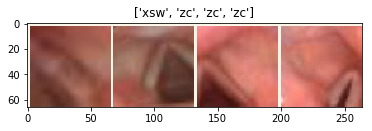

In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(32, 64, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv4 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(64, 128, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv5 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(128, 256, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(256 * 2 * 2, 2)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(dset_loaders['train']):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

CNN (
  (conv1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv3): Sequential (
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv4): Sequential (
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv5): Sequential (
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1024 -> 3)
)
Epoch:  0 | train loss: 1.1213 | test

Process Process-96:
Process Process-93:
Process Process-95:
Process Process-94:
Traceback (most recent call last):
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Traceback (most recent call last):
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/max/anaconda/envs/PyTorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
    r = index_qu

KeyboardInterrupt: 